# Week 8

In [32]:
%reset 

Download the LabMT wordlist. It’s available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.

Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [ ]:
from pathlib import Path
import csv
import pandas as pd

path_to_word_list = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv"


def load_word_list(p: Path):
    
    p = Path(path_to_word_list)
    print("Path:", p)
    print("Exists:", p.exists())
    print("Absolute:", p.resolve())
    print("Current working dir:", Path.cwd())

    if not p.exists():
        print("\nFile not found. Check that the path is correct, the file is accessible, and that Dropbox sync hasn't moved it.")
        # show parent contents to help diagnose
        if p.parent.exists():
            print("\nFiles in parent directory (first 20):")
            for i, fp in enumerate(sorted(p.parent.iterdir())):
                if i >= 20:
                    break
                print(" ", fp.name)
    else:
        # try robust loading: prefer pandas if available, otherwise CSV reader
        try:
            df = pd.read_csv(p, encoding='utf-8', engine='python')
            print("\nCSV loaded with pandas. Shape:", df.shape)
            print("Columns:", list(df.columns))
            # choose word column (first) and score column (first numeric found after)
            # try to auto-detect relevant columns
            word_col_candidates = [c for c in df.columns if 'word' in c.lower()]
            score_col_candidates = [c for c in df.columns if 'happiness' in c.lower() or 'score' in c.lower()]

            if word_col_candidates:
                word_col = word_col_candidates[0]
            else:
                word_col = df.columns[0]  # fallback

            if score_col_candidates:
                score_col = score_col_candidates[0]
            else:
                # fallback: first numeric column
                num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
                score_col = num_cols[0] if num_cols else df.columns[1]

            print(f"Using columns: word='{word_col}', score='{score_col}'")

            w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))

            if score_col is None and df.shape[1] >= 2:
                score_col = df.columns[1]
            if score_col is None:
                raise ValueError("Could not find a score column in the CSV.")
            w_l = dict(zip(df[word_col].astype(str).str.lower(), df[score_col].astype(float)))
            print(f"Loaded {len(w_l)} words into w_l.")
        except Exception as e:
            print("Pandas load failed or not available, falling back to csv module. Error:", e)
            w_l = {}
            try:
                with open(p, 'r', encoding='utf-8') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        if len(row) >= 2:
                            try:
                                word = row[0].strip().lower()
                                score = float(row[1])
                                w_l[word] = score
                            except:
                                continue
                print(f"Fallback: loaded {len(w_l)} words into w_l.")
            except Exception as e2:
                print("Fallback failed:", e2)
    return w_l


def calculate_sentiment(tokens, labmt_data=None):
    """
    Calculate average sentiment score for a list of tokens using LabMT word list
    
    Args:
        tokens (list): List of lowercase tokens/words
        labmt_data (dict, optional): Dictionary with word:score pairs from LabMT
        
    Returns:
        float: Average sentiment score of tokens found in LabMT
    """
    if labmt_data is None:
        # Default to loading the LabMT data
        # You'll need to adjust the path to your LabMT file
        labmt_path = "data/labmt_words.txt"
        labmt_data = {}
        with open(labmt_path, 'r', encoding='utf-8') as f:
            for line in f:
                word, score = line.strip().split('\t')
                labmt_data[word.lower()] = float(score)
    
    # Get scores for tokens that exist in labmt
    scores = [labmt_data[token] for token in tokens if token in labmt_data]
    
    # Return average if we found any scores, otherwise return neutral score (5.0)
    if scores:
        return sum(scores) / len(scores)
    return 5.0
w_l = load_word_list(Path(path_to_word_list))
# Example usage:
text_tokens = ['happy', 'wonderful', 'sad', 'amazing']
sentiment_score = calculate_sentiment(text_tokens, labmt_data=w_l)
print("Sentiment score:", sentiment_score)
    


Path: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Exists: True
Absolute: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Current working dir: c:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Mads

CSV loaded with pandas. Shape: (10187, 5)
Columns: ['Rank', 'Word', 'Word in English', 'Happiness Score', 'Standard Deviation of Ratings']
Using columns: word='Word', score='Happiness Score'
Loaded 10187 words into w_l.
Sentiment score: 6.525


In [44]:

from pathlib import Path
import json
import re
import networkx as nx
import nltk
# nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize

# Paths
path_to_bands_folder = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Noa\Bands")
path_to_word_list = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv"

# Load the sentiment dictionary
w_l = load_word_list(Path(path_to_word_list))

path_to_graph = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Mads\graph_week7.graphml"


# Load or create your graph
# (replace this with your actual graph)
# load the graph from file
G = nx.read_graphml(path_to_graph)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
# Utility: simple tokenizer (split words, lowercase)

def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha()]
# Iterate through band text files
for file in path_to_bands_folder.glob("*.txt"):
    try:
        # Extract band name from filename (e.g. "3 Doors Down.txt" → "3 Doors Down")
        band_name = file.stem
        # print(f"Processing band: {band_name}")

        # Read file content
        text = file.read_text(encoding='utf-8')

        # Try parsing JSON (if stored in JSON format)
        try:
            data = json.loads(text)
            # Extract wikitext if it's stored under that structure
            text = data["query"]["pages"][next(iter(data["query"]["pages"]))]["revisions"][0]["slots"]["main"]["*"]
        except Exception:
            # not JSON or unexpected structure — keep as plain text
            pass

        # Tokenize text
        tokens = tokenize(text)

        # Calculate sentiment
        sentiment_score = calculate_sentiment(tokens, labmt_data=w_l)

        # Add node (if not already in graph)
        # if band_name not in G:
        #     G.add_node(band_name)

        # Set sentiment as node attribute
        if band_name in G:
            
            G.nodes[band_name]["sentiment"] = sentiment_score

        # print(f"{band_name:30s} → Sentiment: {sentiment_score:.2f}")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Check example
print("\nTotal nodes with sentiment:", sum("sentiment" in G.nodes[n] for n in G.nodes))



Path: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Exists: True
Absolute: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Hedonometer.csv
Current working dir: c:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Mads

CSV loaded with pandas. Shape: (10187, 5)
Columns: ['Rank', 'Word', 'Word in English', 'Happiness Score', 'Standard Deviation of Ratings']
Using columns: word='Word', score='Happiness Score'
Loaded 10187 words into w_l.
Graph has 203 nodes and 1210 edges.
Processing band: 10cc
Processing band: 10_Years__band_
Processing band: 311__band_
Processing band: 38_Special__band_
Processing band: 3_Doors_Down
Processing band: ABBA
Processing band: Accept__band_
Processing band: AC_DC
Processing band: Adam_Ant
Processing band: Aerosmith
Processing band: AFI__band_
Processing band: Air_Supply
Processing band: Alanis_Mo

In [38]:
# print number of nodes and edges in G
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")    


Graph has 659 nodes and 1210 edges.


- Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.

- Remember histograms? Create a histogram of all of the artists’s associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.

- Who are the 10 artists with happiest and saddest pages?

Average sentiment: 5.577
Median sentiment: 5.580
Variance: 0.004
25th percentile: 5.535
75th percentile: 5.624


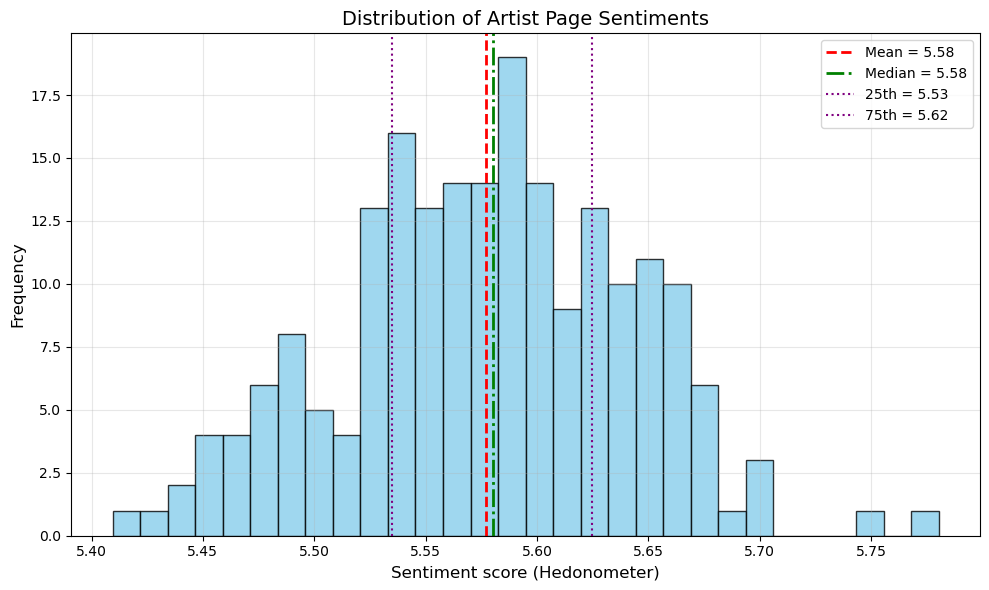

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Extract sentiment values from your graph
sentiments = nx.get_node_attributes(G, "sentiment")

# Convert to numpy array for easy stats
sentiment_values = np.array(list(sentiments.values()))

# Compute summary statistics
mean_val = np.mean(sentiment_values)
median_val = np.median(sentiment_values)
var_val = np.var(sentiment_values)
p25 = np.percentile(sentiment_values, 25)
p75 = np.percentile(sentiment_values, 75)

print(f"Average sentiment: {mean_val:.3f}")
print(f"Median sentiment: {median_val:.3f}")
print(f"Variance: {var_val:.3f}")
print(f"25th percentile: {p25:.3f}")
print(f"75th percentile: {p75:.3f}")

# Histogram
plt.figure(figsize=(10,6))
plt.hist(sentiment_values, bins=30, color="skyblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Artist Page Sentiments", fontsize=14)
plt.xlabel("Sentiment score (Hedonometer)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add vertical lines for summary stats
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")
plt.axvline(p25, color="purple", linestyle=":", linewidth=1.5, label=f"25th = {p25:.2f}")
plt.axvline(p75, color="purple", linestyle=":", linewidth=1.5, label=f"75th = {p75:.2f}")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [46]:
# Sort bands by sentiment
sorted_bands = sorted(sentiments.items(), key=lambda x: x[1])

# 10 saddest
print("\n 10 Saddest artists:")
for band, val in sorted_bands[:10]:
    print(f"{band:30s}  {val:.2f}")

# 10 happiest
print("\n 10 Happiest artists:")
for band, val in sorted_bands[-10:][::-1]:  # reverse for descending
    print(f"{band:30s}  {val:.2f}")



 10 Saddest artists:
Quiet_Riot                      5.41
Skid_Row__American_band_        5.43
White_Zombie__band_             5.44
Rise_Against                    5.45
Pantera                         5.45
Sex_Pistols                     5.46
Dio__band_                      5.46
Damn_Yankees__band_             5.46
Grateful_Dead                   5.46
W_A_S_P___band_                 5.46

 10 Happiest artists:
Boys_Like_Girls                 5.78
Fun__band_                      5.75
The_Cardigans                   5.71
Train__band_                    5.70
Imagine_Dragons                 5.70
Simple_Plan                     5.68
April_Wine                      5.68
Counting_Crows                  5.68
Vampire_Weekend                 5.68
Volbeat                         5.68


Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a community level sentiment.

- Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a .good name for the community).

- What are the three happiest communities?

- what are the three saddest communities?

- Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages?

- Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

### create partition 

In [ ]:

import ast
import networkx as nx
from collections import defaultdict

nodes_without_edges = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_without_edges)

louvain_communities = list(nx.community.louvain_communities(G, seed=42))
louvain_modularity = nx.community.modularity(G, louvain_communities)
print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")

# using louvain_communities
partition = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        partition[node] = i


all_nodes_in_partition = set().union(*partition)
missing_nodes = set(G.nodes()) - all_nodes_in_partition

print(f"Partition covers {len(all_nodes_in_partition)} / {G.number_of_nodes()} nodes.")
if missing_nodes:
    print("Warning: Missing nodes:", list(missing_nodes)[:10], "...")


# --- 2. Create a partition where each community is a genre ---
# Each node is assigned to the community of its *first* listed genre.

communities_by_genre = defaultdict(list)

for node, data in G.nodes(data=True):
    genres = data.get('genres')

    if isinstance(genres, str):
        try:
            # convert stringified list safely (avoid eval for safety)
            genres = ast.literal_eval(genres)
        except Exception:
            genres = [genres]

    if not genres or not isinstance(genres, (list, tuple)) or len(genres) == 0:
        first_genre = "Unknown"
    else:
        first_genre = genres[0]

    communities_by_genre[first_genre].append(node)

# Convert to partition
partition = [set(nodes) for nodes in communities_by_genre.values()]

# Verify coverage
all_nodes = set().union(*partition)
missing = set(G.nodes()) - all_nodes
if missing:
    print(f"Missing {len(missing)} nodes — adding them as 'Unknown'")
    partition.append(missing)
else:
    print("Partition covers all nodes.")

# The modularity function requires a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")

# --- 3. Calculate and report the modularity ---
if G.number_of_edges() > 0:
    modularity_score = nx.community.modularity(G, partition)
    print(f"Modularity (genre-based): {modularity_score:.4f}")
else:
    print("No edges — cannot compute modularity.")


Louvain method found 5 communities with a modularity of 0.3654.
Partition covers 62 / 197 nodes.
Partition covers all nodes.

Created a partition with 73 communities based on the first genre.
🎸 Modularity (genre-based): 0.0646


### Community stats (run partition first)

In [ ]:
from collections import defaultdict, Counter
import numpy as np
import networkx as nx
import pandas as pd

# --- 0) Prep ---
# Use undirected view for "most connected" (degree) and intra-community edges
G_u = G.to_undirected()

# Sentiment dict (some nodes may miss it)
sent_attr = nx.get_node_attributes(G, "sentiment")

# Build a list of (community_key, node_set) for convenience
communities = [(genre, set(nodes)) for genre, nodes in communities_by_genre.items()]

# --- 1) Helper: top-3 most connected (within the community) ---
def top3_within_community(G_undirected, nodes_set, weight="weight"):
    if not nodes_set:
        return []
    H = G_undirected.subgraph(nodes_set)
    # degree weighted if 'weight' exists; otherwise counts edges
    deg = H.degree(weight=weight if any('weight' in d for _, _, d in H.edges(data=True)) else None)
    # sort by degree desc, then by name for tie-stability
    top = sorted(deg, key=lambda kv: (-kv[1], str(kv[0])))[:3]
    return [n for n, _ in top]

# --- 2) Compute per-community stats & names ---
rows = []
for genre, nodes_set in communities:
    # naming via top-3 most connected inside the community
    top3 = top3_within_community(G_u, nodes_set)
    label = ", ".join(top3) if top3 else "(no nodes)"

    # sentiment stats for nodes that have sentiment

    
    svals = [sent_attr[n] for n in nodes_set if n in sent_attr]
    if len(svals) > 0:
        mean_s = float(np.mean(svals))
        med_s  = float(np.median(svals))
        var_s  = float(np.var(svals))
        p25    = float(np.percentile(svals, 25))
        p75    = float(np.percentile(svals, 75))
    else:
        mean_s = med_s = var_s = p25 = p75 = np.nan

    # intra-community edge count (undirected)
    H = G_u.subgraph(nodes_set)
    intra_edges = H.number_of_edges()

    rows.append({
        "community_key": genre,            # usually the first-genre label ("Unknown" for missing)
        "community_name": label,           # top-3 bands
        "n_nodes": len(nodes_set),
        "intra_edges": intra_edges,
        "sent_mean": mean_s,
        "sent_median": med_s,
        "sent_var": var_s,
        "sent_p25": p25,
        "sent_p75": p75,
    })

comm_df = pd.DataFrame(rows).sort_values(["n_nodes", "sent_mean"], ascending=[False, False]).reset_index(drop=True)

# --- FIX: convert sentiment attributes to float ---
sent_attr_raw = nx.get_node_attributes(G, "sentiment")

sent_attr = {}
for n, v in sent_attr_raw.items():
    try:
        if v is not None and str(v).strip() != "":
            sent_attr[n] = float(v)
    except ValueError:
        continue

print(f"Loaded {len(sent_attr)} sentiment values from {G.number_of_nodes()} nodes.")

# --- 3) Overall distribution (for comparison) ---
all_sentiments = np.array([v for v in sent_attr.values() if v is not None])
overall = {
    "mean": float(np.mean(all_sentiments)) if len(all_sentiments) else np.nan,
    "median": float(np.median(all_sentiments)) if len(all_sentiments) else np.nan,
    "var": float(np.var(all_sentiments)) if len(all_sentiments) else np.nan,
    "p25": float(np.percentile(all_sentiments, 25)) if len(all_sentiments) else np.nan,
    "p75": float(np.percentile(all_sentiments, 75)) if len(all_sentiments) else np.nan,
    "std": float(np.std(all_sentiments)) if len(all_sentiments) else np.nan,
    "n": int(len(all_sentiments)),
}
print("Overall sentiment distribution:",
      f"\n  n={overall['n']}",
      f"\n  mean={overall['mean']:.3f}, median={overall['median']:.3f}, var={overall['var']:.3f}",
      f"\n  p25={overall['p25']:.3f}, p75={overall['p75']:.3f}")

# --- 4) Happiest / Saddest communities ---
# Optional: filter out tiny communities that can be noisy (e.g., require >= 5 nodes with sentiment)
def count_with_sent(nodes):
    return sum(1 for n in nodes if n in sent_attr)

comm_df["n_with_sent"] = comm_df["community_key"].map(lambda k: count_with_sent(communities_by_genre[k]))
min_size = 5  # tweak as you like
mask = (comm_df["n_with_sent"] >= min_size) & (~comm_df["sent_mean"].isna())

happiest = comm_df[mask].sort_values("sent_mean", ascending=False).head(3)
saddest  = comm_df[mask].sort_values("sent_mean", ascending=True).head(3)

print("\n=== 3 Happiest communities (filtered) ===")
for _, r in happiest.iterrows():
    # delta vs overall as a z-score and absolute diff
    z = (r["sent_mean"] - overall["mean"]) / overall["std"] if overall["std"] > 0 else np.nan
    print(f"- {r['community_key']}: {r['community_name']} "
          f"(n={r['n_nodes']}, mean={r['sent_mean']:.2f}, Δ={r['sent_mean']-overall['mean']:.2f}, z={z:.2f})")

print("\n=== 3 Saddest communities (filtered) ===")
for _, r in saddest.iterrows():
    z = (r["sent_mean"] - overall["mean"]) / overall["std"] if overall["std"] > 0 else np.nan
    print(f"- {r['community_key']}: {r['community_name']} "
          f"(n={r['n_nodes']}, mean={r['sent_mean']:.2f}, Δ={r['sent_mean']-overall['mean']:.2f}, z={z:.2f})")

# --- 5) (Optional) sanity print: top 10 communities by size with their names and mean sentiment
print("\nTop 10 largest communities:")
print(comm_df[["community_key","community_name","n_nodes","sent_mean"]].head(10).to_string(index=False))


Loaded 487 sentiment values from 659 nodes.
Overall sentiment distribution: 
  n=487 
  mean=5.573, median=5.577, var=0.007 
  p25=5.535, p75=5.620

=== 3 Happiest communities (filtered) ===
- Unknown: 10 Years  band , 3 Doors Down, 311  band  (n=456, mean=5.57, Δ=-0.00, z=-0.00)

=== 3 Saddest communities (filtered) ===
- Unknown: 10 Years  band , 3 Doors Down, 311  band  (n=456, mean=5.57, Δ=-0.00, z=-0.00)

Top 10 largest communities:
    community_key                                  community_name  n_nodes  sent_mean
          Unknown       10 Years  band , 3 Doors Down, 311  band       456   5.572870
 alternative rock     Incubus__band_, Live__band_, Our_Lady_Peace       31   5.629119
        hard rock                    Whitesnake, AC_DC, Aerosmith       22   5.554730
      heavy metal            Metallica, Judas_Priest, Iron_Maiden       14   5.582382
             rock Grateful_Dead, Heart__band_, Traveling_Wilburys       14        NaN
      post-grunge           Daughtry__band

In [ ]:
print("Example node attributes:")
for node, data in list(old_G.nodes(data=True))[:5]:
    print(node, "→", data)


Example node attributes:
10cc → {'genres': "['articles']"}
311__band_ → {'genres': "['alternative rock', 'rap rock', 'reggae rock', 'funk rock', 'funk metal']"}
38_Special__band_ → {'genres': "['songs', '38-special-mn0000500781']"}
3_Doors_Down → {'genres': "['post-grunge', '3-doors-down-mn0000923323', '2015']"}
Accept__band_ → {'genres': "['heavy metal']"}
